In [ ]:
# Installation of some requirements
# %pip install albumentations
# %pip install ultralytics

In [ ]:
# Kaggle dataset download
# !kaggle datasets download juanthomaswijaya/indonesian-license-plate-dataset --path data --unzip

In [ ]:
# %matplotlib inline

In [1]:
import numpy as np
import torch # If you use PyTorch later for training
import random
import os

# Choose an integer seed (e.g., 42, 0, or any number)
SEED = 42

def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # If you use PyTorch, uncomment these:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(SEED)

In [15]:
import cv2
import albumentations as A
from glob import glob

# Paths
INPUT_DATA_ROOT = "../data/raw/Indonesian License Plate Dataset/"

input_images = os.path.join(INPUT_DATA_ROOT, "images")
input_labels = os.path.join(INPUT_DATA_ROOT, "labels")

# OUTPUT Paths (A new folder to store the augmented data, usually outside of 'raw')
OUTPUT_DATA_ROOT = "../data/processed/"

output_images = os.path.join(OUTPUT_DATA_ROOT, "images")
output_labels = os.path.join(OUTPUT_DATA_ROOT, "labels")

# --- END: Updated Paths ---

# Create output directories
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

# Define augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=5, p=0.5),
    A.Perspective(scale=(0.02, 0.05)),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.5),
],
bbox_params=A.BboxParams(
    format='yolo', 
    label_fields=['class_labels'],
    # Add clip=True to ensure all coordinates are strictly within [0.0, 1.0]
    clip=True,
    min_area=1.0
))

# Loop through all images
for subdir in os.listdir(input_images):
    # Construct the full paths for the current subdirectory
    current_input_image_dir = os.path.join(input_images, subdir)
    current_input_label_dir = os.path.join(input_labels, subdir)

    # 🛑 FIX 2: Create the corresponding output subdirectories
    current_output_image_dir = os.path.join(output_images, subdir)
    current_output_label_dir = os.path.join(output_labels, subdir)

    os.makedirs(current_output_image_dir, exist_ok=True)
    os.makedirs(current_output_label_dir, exist_ok=True)
    
    print(f"Processing directory: {subdir}")

    # Loop through all images in the subdirectory
    # Using os.path.join is safer than f-string concatenation for paths
    for img_path in glob(os.path.join(current_input_image_dir, "*.jpg")):
        filename = os.path.basename(img_path)
        
        # 🛑 FIX 1: Correctly construct the label path using the subdirectory path
        label_path = os.path.join(current_input_label_dir, filename.replace(".jpg", ".txt"))

        # Safety Check: Ensure the label file exists before proceeding
        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {filename} in {subdir}. Skipping.")
            continue
            
        # Read image and labels (continue with your original logic)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Could not read image {img_path}. Skipping.")
            continue
            
        h, w, _ = image.shape # This is for context, not strictly needed by the augmentation code

        # ... (rest of the label reading, augmentation, and saving logic) ...

        with open(label_path, "r") as f:
            labels = f.readlines()

        bboxes = []
        class_labels = []
        for label in labels:
            try:
                cls, x, y, bw, bh = map(float, label.strip().split())
                bboxes.append([x, y, bw, bh])
                class_labels.append(int(cls))
            except Exception as e:
                 # Added error handling for malformed lines
                print(f"Error processing label line in {label_path}: {e}. Skipping image.")
                continue

        # Apply transformation
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        # 🛑 FIX 2 (Final Save): Save augmented files into the correct OUTPUT subdirectory
        
        # Adding 'aug_' prefix is good practice to distinguish augmented files
        aug_filename = f"aug_{filename}" 

        # Save augmented image
        save_path_img = os.path.join(current_output_image_dir, aug_filename)
        cv2.imwrite(save_path_img, aug_img)

        # Save updated YOLO labels
        save_path_lbl = os.path.join(current_output_label_dir, aug_filename.replace(".jpg", ".txt"))
        with open(save_path_lbl, "w") as f:
            for cls, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

print("✅ Data augmentation complete!")


/home/bryan_santosa/conda_envs/torchgpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing directory: test
Processing directory: train
Processing directory: val
✅ Data augmentation complete!


In [16]:
from ultralytics import YOLO
import torch

print("YOLO version:", YOLO._version)
print("CUDA available:", torch.cuda.is_available())
print("Device being used:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


YOLO version: 1
CUDA available: True
Device being used: NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
DATA_YAML_PATH = '../data.yaml'

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load a pre-trained YOLOv8-nano model
model = YOLO('yolov8n.pt')

model.model.to(target_device) 

# 3. Verify the change (using the reliable check)
first_param_device = next(model.model.parameters()).device

print("✅ Model device (PyTorch check):", first_param_device)

print("Starting YOLOv8 training...")
results = model.train(
    data=DATA_YAML_PATH,     # Path to the data configuration file
    epochs=40,              # Number of epochs (adjust as needed)
    imgsz=640,               # Input image size (standard for YOLO)
    batch=6,                # Batch size (reduce if you run out of GPU memory)
    name='lp_detection_v3',  # Name for the results folder in 'runs/detect
    # Optional: use the 'freeze' argument if you want to freeze the backbone 
    amp=True,
    device=0,  
    lr0=1e-3
)

print("Training complete. Results saved in runs/detect/lp_detection_v3")

✅ Model device (PyTorch check): cuda:0
Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.223 🚀 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937,

In [20]:
evaluate = model.val()

Ultralytics 8.3.223 🚀 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.7±0.1 ms, read: 134.6±15.8 MB/s, size: 1701.0 KB)
val: Scanning /mnt/d/Uni/Semester 5/Computer Vision/Plate-Recognition/data/processed/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 119.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.7s0.4ss
                   all        100        179       0.98      0.961      0.993      0.729
Speed: 8.8ms preprocess, 7.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /mnt/d/Uni/Semester 5/Computer Vision/Plate-Recognition/notebooks/runs/detect/val4


columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
                              0          1          2          3          4
epoch                  1.000000   2.000000   3.000000   4.000000   5.000000
time                  21.254500  39.879400  58.225500  76.807000  94.631500
train/box_loss         1.495820   1.367810   1.340050   1.340440   1.330070
train/cls_loss         2.545190   1.470670   1.236440   1.130550   1.042730
train/dfl_loss         1.142130   1.064740   1.078760   1.048280   1.042080
metrics/precision(B)   0.950420   0.870700   0.957740   0.931430   0.960400
metrics/recall(B)      0.856820   0.827650   0.886350   0.910630   0.948410
metrics/mAP50(B)       0.959420   0.916750   0.957720   0.963430   0.979110
metrics/mAP50-95(B)    0.527450   0.561900   0.585330   0.611060   0.

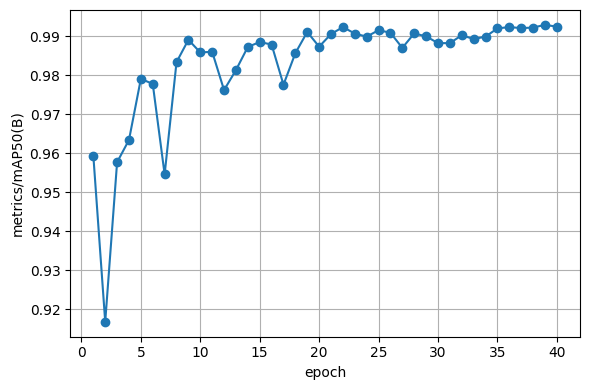

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("runs/detect/lp_detection_v3/results.csv")

# Inspect columns and head to see what's actually in the CSV
print("columns:", df.columns.tolist())
print(df.head().T)

# Pick the mAP column robustly
map_cols = [c for c in df.columns if "mAP50" in c or "map50" in c.lower() or "mAP" in c]
if not map_cols:
    raise ValueError("No mAP column found in results.csv. Columns: " + ", ".join(df.columns))
col = map_cols[0]
print("Using metric column:", col)

# Convert to numeric (coerce errors -> NaN) and warn if any NaNs
y = pd.to_numeric(df[col], errors="coerce")
if y.isnull().any():
    print("Warning: some values in the metric column could not be converted to numeric and became NaN")

# Use epoch column if present else use dataframe index
x = df["epoch"] if "epoch" in df.columns else df.index

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o")
plt.xlabel("epoch" if "epoch" in df.columns else "index")
plt.ylabel(col)
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import os
import json
import cv2
from ultralytics import YOLO

YOLO_MODEL_PATH = "./runs/detect/lp_detection_v3/weights/best.pt"
INPUT_DIR = "../data/processed/images/"
OUTPUT_DIR = "../data/cropped/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

model = YOLO(YOLO_MODEL_PATH)

mapping = {}

for class_name in os.listdir(INPUT_DIR):
    input_class_dir = os.path.join(INPUT_DIR, class_name)
    output_class_dir = os.path.join(OUTPUT_DIR, class_name)

    # Create output directory for this class
    os.makedirs(output_class_dir, exist_ok=True)

    for filename in os.listdir(input_class_dir):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(input_class_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        results = model.predict(img, verbose=False)
        boxes = results[0].boxes

        bboxes = boxes.xyxy.cpu().numpy()
        confs = boxes.conf.cpu().numpy()

        cropped_entries = []  # reset for each image

        for i, (x1, y1, x2, y2) in enumerate(bboxes[:, :4]):
            conf = confs[i]
            if conf < 0.5:
                continue

            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            crop = img[y1:y2, x1:x2]

            crop_name = f"{os.path.splitext(filename)[0]}_plate{i+1}.jpg"
            crop_path = os.path.join(output_class_dir, crop_name)

            cv2.imwrite(crop_path, crop)

            cropped_entries.append({
                "crop": crop_name,
                "confidence": float(conf),
                "bbox": [x1, y1, x2, y2]
            })

        if cropped_entries:
            mapping[filename] = cropped_entries

# Save mapping once at the end
mapping_file = os.path.join(OUTPUT_DIR, "detections.json")
with open(mapping_file, "w") as f:
    json.dump(mapping, f, indent=4)

print("Done!")


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

def preprocess_for_ocr(img, target_h=32, target_w=128):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. (Optional) LIGHT denoise — avoid distortion
    # denoised = cv2.fastNlMeansDenoising(gray, h=10)

    # 3. Resize to target OCR input size
    resized = cv2.resize(gray, (target_w, target_h), interpolation=cv2.INTER_AREA)

    return resized


<h1> Preprocess OCR dataset

In [33]:
cropped_OCR_dir = "../data/cropped/"
output_OCR_dir = "../data/trainOCR/images/"

os.makedirs(output_OCR_dir, exist_ok=True)

for dataset_category in os.listdir(cropped_OCR_dir):
    print(full_dataset_category)
    print(os.listdir(cropped_OCR_dir))
    print(dataset_category)
    full_dataset_category = os.path.join(cropped_OCR_dir, dataset_category)
    output_category_dir = os.path.join(output_OCR_dir, dataset_category)
    if not os.path.isdir(full_dataset_category):
        continue
    os.makedirs(output_category_dir, exist_ok=True)
    for filename in os.listdir(full_dataset_category):
        full_cropped_image_path = os.path.join(full_dataset_category, filename)
        full_output_image_path = os.path.join(output_category_dir, filename)

        # --- Load image ---
        img = cv2.imread(full_cropped_image_path)
        if img is None:
            print(f"❌ Cannot read {full_cropped_image_path}, skipping...")
            continue

        # --- Preprocess the image ---
        processed_img = preprocess_for_ocr(img)

        # --- IMPORTANT: Convert to uint8 before saving ---
        processed_img_uint8 = (processed_img * 255).astype("uint8")

        # --- Save the processed image ---
        cv2.imwrite(full_output_image_path, processed_img_uint8)

print("\n🎉 All license plates have been preprocessed for OCR!")

../data/cropped/val
['detections.json', 'test', 'train', 'val']
detections.json
../data/cropped/detections.json
['detections.json', 'test', 'train', 'val']
test
../data/cropped/test
['detections.json', 'test', 'train', 'val']
train
../data/cropped/train
['detections.json', 'test', 'train', 'val']
val

🎉 All license plates have been preprocessed for OCR!


<h1> Training OCR recognition model

In [44]:
# --- LPRNet training adapted to your script ---
import os
import cv2
import math
import time
import torch
import numpy as np
from typing import List
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Optional fast Levenshtein
try:
    import editdistance
    def levenshtein(a,b): return editdistance.eval(a,b)
except Exception:
    def levenshtein(a, b):
        la, lb = len(a), len(b)
        dp = list(range(lb+1))
        for i in range(1, la+1):
            prev = dp[:]
            dp[0] = i
            for j in range(1, lb+1):
                dp[j] = min(prev[j] + 1, dp[j-1] + 1, prev[j-1] + (0 if a[i-1]==b[j-1] else 1))
        return dp[lb]

# -------------------------
# User config / paths (use your existing values)
# -------------------------
ROOT = "../data/raw/Indonesian License Plate Recognition Dataset"
TARGET_H = 32
TARGET_W = 128
BATCH_SIZE = 64
NUM_EPOCHS = 150
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "./OCR/best_lprnet.pth"
os.makedirs("./OCR/", exist_ok=True)


In [22]:
# -------------------------
# Utilities: read classes.names
# -------------------------
def load_classes(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [l.rstrip("\n") for l in f if l.strip()!=""]
    return lines

# -------------------------
# Data & Dataloaders
# -------------------------
# load classes
classes_path = os.path.join(ROOT, "classes.names")
class_names = load_classes(classes_path)
# char2idx, idx2char
char2idx = {c:i for i,c in enumerate(class_names)}
idx2char = {i:c for c,i in char2idx.items()}

In [49]:


# -------------------------
# Build transcription from YOLO character labels
# label line format: "<class_id> <cx> <cy> <w> <h>"
# We sort by cx to get left-to-right reading order.
# -------------------------
def parse_label_file(label_path, class_names):
    chars = []
    try:
        with open(label_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                cx = float(parts[1])
                #cy = float(parts[2])
                #w = float(parts[3]); h = float(parts[4])
                chars.append((cx, class_names[cls] if cls < len(class_names) else "?"))
    except FileNotFoundError:
        return ""
    # sort by cx and join
    chars.sort(key=lambda x: x[0])
    transcription = "".join([c for _, c in chars])
    return transcription

# -------------------------
# Dataset
# -------------------------
class PlateOCRDataset(Dataset):

    def __init__(self, root: str, split: str, class_names, transform=None):
        assert split in ("train", "val", "test"), "split must be one of 'train','val','test'"

        self.root = root
        self.split = split
        self.img_dir = os.path.join(root, "images", split)
        self.lbl_dir = os.path.join(root, "labels", split)
        if not os.path.isdir(self.img_dir):
            raise FileNotFoundError(f"Images directory not found: {self.img_dir}")
        if not os.path.isdir(self.lbl_dir):
            # It's OK to allow missing label files per image, but folder should exist
            raise FileNotFoundError(f"Labels directory not found: {self.lbl_dir}")

        # collect image files
        self.files = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

        self.class_names = class_names
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def _build_label_path(self, image_filename):
        name, _ = os.path.splitext(image_filename)
        return os.path.join(self.lbl_dir, name + ".txt")

    def __getitem__(self, idx):
        filename = self.files[idx]
        img_path = os.path.join(self.img_dir, filename)
        lbl_path = self._build_label_path(filename)

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")

        # --- preprocess (still numpy 2D array H×W) ---
        if self.transform is not None:
            img_proc = self.transform(img)
        else:
            img_proc = img

        # --- convert to tensor CHW ---
        # img_proc shape: (H, W) → (1, H, W)
        img_tensor = torch.from_numpy(img_proc)
        img_tensor = img_tensor.unsqueeze(0) 
        img_tensor = img_tensor.float() / 255.0

        # Build transcription string
        transcription = ""
        if os.path.exists(lbl_path):
            chars = []
            with open(lbl_path, "r") as f:
                for line in f:
                    parts = line.split()
                    if len(parts) < 5:
                        continue
                    cls_id = int(parts[0])
                    cx = float(parts[1])
                    char = self.class_names[cls_id]
                    chars.append((cx, char))
            chars.sort(key=lambda x: x[0])
            transcription = "".join([c for _, c in chars])

        return img_tensor, transcription
    
def collate_fn(batch, char2idx):
    images = []
    labels = []
    texts = []

    for img_tensor, text in batch:
        images.append(img_tensor)                    # tensor (1,H,W)
        seq = [char2idx[c] for c in text]            # map chars -> ints 0..num_chars-1
        labels.append(seq)
        texts.append(text)

    images = torch.stack(images).float()             # (B,1,H,W)

    # flatten labels into 1D tensor required by CTCLoss
    flat = [x for seq in labels for x in seq]
    if len(flat) == 0:
        targets = torch.tensor([], dtype=torch.long)
    else:
        targets = torch.tensor(flat, dtype=torch.long)

    target_lengths = torch.tensor([len(seq) for seq in labels], dtype=torch.long)

    # we do NOT set input_lengths here (compute from logits at runtime)
    return images, targets, target_lengths, texts

# -------------------------
# LPRNet model (grayscale / 1-channel input)
# -------------------------
class SmallBasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=(3,1), padding=(1,0)),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=(1,3), padding=(0,1)),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, num_chars, dropout_rate=0.5):
        super().__init__()
        # input channels = 1 (grayscale)
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            SmallBasicBlock(64, 128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            SmallBasicBlock(128, 256),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            SmallBasicBlock(256, 256)
        )
        # head -> produce num_chars + 1 (for blank) channels
        self.head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv2d(256, num_chars+1, kernel_size=1),
            nn.BatchNorm2d(num_chars+1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # x: (B,1,H,W)
        feat = self.backbone(x)                    # (B, 256, Hc, Wc)
        out = self.head(feat)                      # (B, C, Hc, Wc) where C=num_chars+1
        out = out.mean(dim=2)                      # collapse height -> (B, C, Wc)
        out = out.permute(2,0,1)                   # (T=Wc, B, C)
        return out

# -------------------------
# Greedy decode (CTC) mapping indices -> chars
# -------------------------
def greedy_decode(logits, idx2char):
    # logits: T x B x C
    probs = torch.softmax(logits, dim=-1)
    max_idx = torch.argmax(probs, dim=-1)  # T x B
    T, B = max_idx.shape
    blank_index = len(idx2char)-1           # blank = num_chars
    results = []
    for b in range(B):
        last = -1
        chars = []
        for t in range(T):
            v = int(max_idx[t,b].item())
            if v != last and v != blank_index and v < len(idx2char):
                chars.append(idx2char[v])
            last = v
        results.append("".join(chars))
    return results


def ctc_beam_search(log_probs, beam_width, blank=36):
    """
    log_probs: Tensor of shape (T, C) - log-softmax probabilities
    beam_width: number of beams to keep
    blank: index of CTC blank token

    Returns:
        best decoded string (no repeated chars, no blanks)
    """
    T, C = log_probs.shape

    # Beams: dictionary mapping sequence tuples -> log-prob
    beams = {(): 0.0}  # empty sequence with 0 log-prob

    for t in range(T):
        next_beams = defaultdict(lambda: -float("inf"))
        probs_t = log_probs[t]  # shape (C,)

        for seq, seq_logprob in beams.items():
            # Option 1: Extend with blank
            new_logprob = seq_logprob + probs_t[blank].item()
            next_beams[seq] = max(next_beams[seq], new_logprob)

            # Option 2: Extend with character k
            for k in range(C):
                if k == blank:
                    continue
                new_seq = seq + (k,)

                # If repeating same char as previous timestep → no duplicate collapse
                if len(seq) > 0 and seq[-1] == k:
                    new_logprob = seq_logprob + probs_t[k].item()
                else:
                    new_logprob = seq_logprob + probs_t[k].item()

                next_beams[new_seq] = max(next_beams[new_seq], new_logprob)

        # Keep only top beam_width beams
        beams = dict(sorted(next_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width])

    # Pick best beam
    best_seq = max(beams.items(), key=lambda x: x[1])[0]

    # Collapse repeated characters & remove blanks
    collapsed = []
    prev = None
    for c in best_seq:
        if c != blank and c != prev:
            collapsed.append(c)
        prev = c

    return collapsed

def beam_search_decode_batch(logits, beam_width, blank=0):
    """
    logits: (B, T, C) raw output from LPRNet
    Returns: list[str] decoded texts
    """
    log_probs = torch.log_softmax(logits, dim=2)
    results = []

    for b in range(log_probs.size(0)):
        seq = ctc_beam_search(log_probs[b].cpu(), beam_width, blank)
        text = "".join([idx2char[c] for c in seq])
        results.append(text)

    return results

# -------------------------
# CER calculation
# -------------------------
def cer(preds: List[str], gts: List[str]):
    total_ed = 0
    total_chars = 0
    for p,t in zip(preds, gts):
        total_ed += levenshtein(p, t)
        total_chars += max(1, len(t))
    return total_ed / total_chars

In [53]:

train_ds = PlateOCRDataset(root=ROOT, split="train", class_names=class_names, transform=preprocess_for_ocr)
val_ds   = PlateOCRDataset(root=ROOT, split="val",   class_names=class_names, transform=preprocess_for_ocr)
test_ds  = PlateOCRDataset(root=ROOT, split="test",  class_names=class_names, transform=preprocess_for_ocr)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: collate_fn(b, char2idx))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, char2idx))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, char2idx))
# -------------------------
# Recommended hyperparams
# -------------------------
LEARNING_RATE = 1e-4   # lower LR from 1e-3 -> 1e-4 for stability
GRAD_CLIP = 5.0        # clip gradients to stabilize

num_chars = len(class_names)

model = LPRNet(num_chars).to(DEVICE)
ctc_loss = nn.CTCLoss(blank=len(idx2char)-1, zero_infinity=True)  # blank index = num_chars
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

# -------------------------
# Training loop (computes input_lengths dynamically)
# -------------------------
def get_input_length(logits_T):  # logits shape T x B x C -> T
    return logits_T.size(0)

# -------------------------
# Training loop (fixed)
# -------------------------
best_val_cer = 1.0
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n_batches = 0
    t0 = time.time()

    for images, targets, target_lengths, texts in train_loader:
        # skip empty labels
        if targets.numel() == 0:
            continue

        images = images.to(DEVICE)               # (B,1,H,W)
        targets = targets.to(DEVICE)             # flattened 1D tensor
        target_lengths = target_lengths.to(DEVICE)

        logits = model(images)                   # (T, B, C) - raw scores
        # IMPORTANT: CTCLoss expects log-probabilities (i.e. log_softmax)
        logp = nn.functional.log_softmax(logits, dim=-1)

        T = logp.size(0)
        B = logp.size(1)
        input_lengths = torch.full((B,), fill_value=T, dtype=torch.long, device=DEVICE)
        # print("LOGITS SHAPE:", logits.shape)
        # print("FIRST LOGIT ROW:", logits[:,0,:].argmax(dim=-1))
        loss = ctc_loss(logp, targets, input_lengths, target_lengths)

        opt.zero_grad()
        loss.backward()

        # gradient clipping (helps avoid collapse)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        opt.step()

        epoch_loss += loss.item()
        n_batches += 1

    avg_loss = epoch_loss / max(1, n_batches)
    elapsed = time.time() - t0

    # -------------------------
    # Quick validation debug (first batch only, like you had)
    # -------------------------
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for batch_i, (images, targets, target_lengths, texts) in enumerate(val_loader):
            images = images.to(DEVICE)
            logits = model(images)                # (T, B, C)
            # For decoding we can use softmax (not log softmax)
            batch_preds = greedy_decode(logits,idx2char)
            preds.extend(batch_preds)
            gts.extend(texts)

            # debug printing for the first val batch
            if batch_i == 0:
                T, B, C = logits.shape
                print(f"\nDEBUG: val batch {batch_i} -> logits {logits.shape}, targets.len={targets.numel()}, target_lengths.shape={target_lengths.shape}, texts.len={len(texts)}")
                sum_tlen = int(target_lengths.sum().item()) if target_lengths.numel() > 0 else 0
                print("DEBUG: sum(target_lengths) =", sum_tlen, " targets.numel() =", targets.numel())
                for i in range(min(8, B)):
                    print(f" SAMP {i}: GT='{texts[i]}'  PRED='{batch_preds[i]}'")
                # for i in range(5):
                #      print("GT=", texts[i], " GREE=", greedy_decode(logits[:,i,:], idx2char))
                probs = torch.softmax(logits, dim=-1)
                blank_index = 36
                blank_probs = float(probs[:, :, blank_index].mean().cpu().item())
                char_probs = float(probs[:, :, :blank_index].mean().cpu().item())
                print(f"DEBUG: avg blank prob = {blank_probs:.4f}, avg char prob = {char_probs:.4f}")
                print(texts[:8])
                print(target_lengths[:8])
                print(targets[:20])
            # only evaluate first batch for quick debug
            break

    val_cer = cer(preds, gts) if len(gts) > 0 else 1.0
    print(f"Epoch {epoch}/{NUM_EPOCHS}  loss={avg_loss:.4f}  val_CER={val_cer:.4f}  time={elapsed:.1f}s")

    # save best
    if val_cer < best_val_cer:
        best_val_cer = val_cer
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": opt.state_dict(),
            "char2idx": char2idx,
            "idx2char": idx2char
        }, BEST_MODEL_PATH)
        print("Saved best model:", BEST_MODEL_PATH)



DEBUG: val batch 0 -> logits torch.Size([16, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 SAMP 0: GT='B9079FXX'  PRED=''
 SAMP 1: GT='B1950NZG'  PRED=''
 SAMP 2: GT='H9019YC'  PRED=''
 SAMP 3: GT='G7D'  PRED=''
 SAMP 4: GT='AD1067DC'  PRED=''
 SAMP 5: GT='L2905NC'  PRED=''
 SAMP 6: GT='H8011EQ'  PRED=''
 SAMP 7: GT='B1986VMQ'  PRED=''
DEBUG: avg blank prob = 0.0322, avg char prob = 0.0269
['B9079FXX', 'B1950NZG', 'H9019YC', 'G7D', 'AD1067DC', 'L2905NC', 'H8011EQ', 'B1986VMQ']
tensor([8, 8, 7, 3, 8, 7, 7, 8])
tensor([11,  9,  0,  7,  9, 15, 33, 33, 11,  1,  9,  5,  0, 23, 35, 16, 17,  9,
         0,  1])
Epoch 1/150  loss=5.9496  val_CER=1.0000  time=20.7s

DEBUG: val batch 0 -> logits torch.Size([16, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 SAMP 0: GT='B9079FXX'  PRED='N'
 SAMP 1: GT='B1950NZG'  PRED='

In [43]:
char2idx['_'] = 36
print("Num classes from model:", logits.shape[2])
print("Num classes from idx2char:", len(idx2char))
print("Num classes from char2idx:", len(char2idx))
num_chars = len(class_names)
print("len(class_names):", num_chars)
print(char2idx)
print(idx2char)

Num classes from model: 37
Num classes from idx2char: 37
Num classes from char2idx: 37
len(class_names): 36
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '_': 36}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: '_'}


In [54]:
for epoch in range(1, 50 + 1):
    model.train()
    epoch_loss = 0.0
    n_batches = 0
    t0 = time.time()

    for images, targets, target_lengths, texts in train_loader:
        # skip empty labels
        if targets.numel() == 0:
            continue

        images = images.to(DEVICE)               # (B,1,H,W)
        targets = targets.to(DEVICE)             # flattened 1D tensor
        target_lengths = target_lengths.to(DEVICE)

        logits = model(images)                   # (T, B, C) - raw scores
        # IMPORTANT: CTCLoss expects log-probabilities (i.e. log_softmax)
        logp = nn.functional.log_softmax(logits, dim=-1)

        T = logp.size(0)
        B = logp.size(1)
        input_lengths = torch.full((B,), fill_value=T, dtype=torch.long, device=DEVICE)
        # print("LOGITS SHAPE:", logits.shape)
        # print("FIRST LOGIT ROW:", logits[:,0,:].argmax(dim=-1))
        loss = ctc_loss(logp, targets, input_lengths, target_lengths)

        opt.zero_grad()
        loss.backward()

        # gradient clipping (helps avoid collapse)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        opt.step()

        epoch_loss += loss.item()
        n_batches += 1

    avg_loss = epoch_loss / max(1, n_batches)
    elapsed = time.time() - t0

    # -------------------------
    # Quick validation debug (first batch only, like you had)
    # -------------------------
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for batch_i, (images, targets, target_lengths, texts) in enumerate(val_loader):
            images = images.to(DEVICE)
            logits = model(images)                # (T, B, C)
            # For decoding we can use softmax (not log softmax)
            batch_preds = greedy_decode(logits,idx2char)
            preds.extend(batch_preds)
            gts.extend(texts)

            # debug printing for the first val batch
            if batch_i == 0:
                T, B, C = logits.shape
                print(f"\nDEBUG: val batch {batch_i} -> logits {logits.shape}, targets.len={targets.numel()}, target_lengths.shape={target_lengths.shape}, texts.len={len(texts)}")
                sum_tlen = int(target_lengths.sum().item()) if target_lengths.numel() > 0 else 0
                print("DEBUG: sum(target_lengths) =", sum_tlen, " targets.numel() =", targets.numel())
                for i in range(min(8, B)):
                    print(f" SAMP {i}: GT='{texts[i]}'  PRED='{batch_preds[i]}'")
                # for i in range(5):
                #      print("GT=", texts[i], " GREE=", greedy_decode(logits[:,i,:], idx2char))
                probs = torch.softmax(logits, dim=-1)
                blank_index = 36
                blank_probs = float(probs[:, :, blank_index].mean().cpu().item())
                char_probs = float(probs[:, :, :blank_index].mean().cpu().item())
                print(f"DEBUG: avg blank prob = {blank_probs:.4f}, avg char prob = {char_probs:.4f}")
                print(texts[:8])
                print(target_lengths[:8])
                print(targets[:20])
            # only evaluate first batch for quick debug
            break

    val_cer = cer(preds, gts) if len(gts) > 0 else 1.0
    print(f"Epoch {epoch}/{NUM_EPOCHS}  loss={avg_loss:.4f}  val_CER={val_cer:.4f}  time={elapsed:.1f}s")

    # save best
    if val_cer < best_val_cer:
        best_val_cer = val_cer
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": opt.state_dict(),
            "char2idx": char2idx,
            "idx2char": idx2char
        }, BEST_MODEL_PATH)
        print("Saved best model:", BEST_MODEL_PATH)


DEBUG: val batch 0 -> logits torch.Size([16, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 SAMP 0: GT='B9079FXX'  PRED='B9A9079A'
 SAMP 1: GT='B1950NZG'  PRED='B1950NZG'
 SAMP 2: GT='H9019YC'  PRED='H9019YC'
 SAMP 3: GT='G7D'  PRED='G1739QI'
 SAMP 4: GT='AD1067DC'  PRED='AD067DUC'
 SAMP 5: GT='L2905NC'  PRED='L2905NWC'
 SAMP 6: GT='H8011EQ'  PRED='H80117ED'
 SAMP 7: GT='B1986VMQ'  PRED='B1986VMQ'
DEBUG: avg blank prob = 0.0468, avg char prob = 0.0265
['B9079FXX', 'B1950NZG', 'H9019YC', 'G7D', 'AD1067DC', 'L2905NC', 'H8011EQ', 'B1986VMQ']
tensor([8, 8, 7, 3, 8, 7, 7, 8])
tensor([11,  9,  0,  7,  9, 15, 33, 33, 11,  1,  9,  5,  0, 23, 35, 16, 17,  9,
         0,  1])
Epoch 1/150  loss=0.2709  val_CER=0.2234  time=20.4s

DEBUG: val batch 0 -> logits torch.Size([16, 64, 37]), targets.len=470, target_lengths.shape=torch.Size([64]), texts.len=64
DEBUG: sum(target_lengths) = 470  targets.numel() = 470
 

In [57]:
# -------------------------
# Final test evaluation using best model
# -------------------------
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()
all_preds, all_gts = [], []
with torch.no_grad():
    for (images, targets, target_lengths, texts) in test_loader:
        images = images.to(DEVICE)
        logits = model(images)
        preds_batch = greedy_decode(logits.cpu(), idx2char)
        all_preds.extend(preds_batch)
        all_gts.extend(texts)
print("Sample preds:", all_preds[:5])
print("Sample gts:", all_gts[:5])
for i, gt in enumerate(all_gts):
    if not isinstance(gt, str):
        print("Non-string GT found at index", i, ":", gt, type(gt))

test_cer = cer(all_preds, all_gts)
print("Final Test CER:", test_cer)


/tmp/ipykernel_12947/2103109911.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


Sample preds: ['B9140BCD', 'B2407U4O', 'B2842PKM', 'BG1352AE', 'B2634UZF']
Sample gts: ['B9140BCD', 'B2407UZO', 'B2842PKM', 'BG1352AE', 'B2634UZF']
Final Test CER: 0.33883161512027493


<h1> Evaluate on cropped dataset

In [58]:
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

idx2char = ckpt["idx2char"]

/tmp/ipykernel_12947/3895466330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


In [79]:
import glob
from tqdm import tqdm
img_paths = []
for split in ["train", "val", "test"]:
    img_paths.extend(glob.glob(f"../data/cropped/{split}/*.jpg"))
    img_paths.extend(glob.glob(f"../data/cropped/{split}/*.png"))

print("Found", len(img_paths), "cropped images.")

# -- 2. match label file
label_dir = "../data/raw/Indonesian License Plate Recognition Dataset/labels"

def matching_label_path(img_path):
    """
    Image name format:
        aug_train001_plate1.jpg
        aug_test003_plate2.jpg
        aug_val010_plate1.jpg

    Label format:
        train001_1.txt
        test003_2.txt
        val010_1.txt
    """

    name = os.path.basename(img_path)  # e.g., "aug_train001_plate1.jpg"

    # Ensure it contains one of the splits
    if not any(s in name for s in ["train", "test", "val"]):
        return None

    # Extract split
    if "train" in name:
        split = "train"
    elif "test" in name:
        split = "test"
    else:
        split = "val"

    # Remove prefix until split
    part = name[name.index(split):]   
    # "train001_plate1.jpg"

    # Split into ["train001", "plate1.jpg"]
    pieces = part.split("_")
    if len(pieces) < 2:
        return None

    # Extract ID from "train001"
    idnum = "".join([c for c in pieces[0] if c.isdigit()])  # "001"

    # Extract plate index from "plate1.jpg"
    plate = "".join([c for c in pieces[1] if c.isdigit()])  # "1"

    # Construct label filename
    label_name = f"{split}/{split}{idnum}_{plate}.txt"

    label_path = os.path.join(label_dir, label_name)
    # print(label_path)
    return label_path if os.path.exists(label_path) else None


# ------------------------------------------------------------
# Evaluation loop
# ------------------------------------------------------------
for img_path in tqdm(img_paths):

    label_path = matching_label_path(str(img_path))
    if label_path is None:
        print("[WARN] No label for:", img_path)
        continue

    # ---------- Load GT ----------
    with open(label_path, "r") as f:
        gt = f.read().strip()

    # ---------- Preprocess (MATCH TRAINING EXACTLY) ----------
    img = cv2.imread(str(img_path))                          # BGR uint8
    img_proc = preprocess_for_ocr(img)                       # MUST NOT normalize
    img_proc = img_proc.astype("float32")                    # Convert dtype only

    img_tensor = (
        torch.tensor(img_proc, dtype=torch.float32)
             .unsqueeze(0)                                   # batch
             .unsqueeze(0)                                   # channel
             .to(DEVICE)
    )

    # ---------- Inference ----------
    with torch.no_grad():
        logits = model(img_tensor)   # (T,1,C)
        pred = greedy_decode(logits.cpu(), idx2char)[0]

    all_preds.append(pred)
    all_gts.append(gt)


# ============================================================
# METRIC
# ============================================================

final_cer = cer(all_preds, all_gts)

print("==========================================")
print(" OCR Evaluation on CROPPED dataset")
print(" Total samples:", len(all_preds))
print(" Final CER:", final_cer)
print("==========================================")

Found 1948 cropped images.


  0%|          | 7/1948 [00:00<00:30, 62.87it/s]

[WARN] No label for: ../data/cropped/train/aug_train001_plate2.jpg


  2%|▏         | 48/1948 [00:00<00:35, 53.07it/s]

[WARN] No label for: ../data/cropped/train/aug_train026_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train028_plate2.jpg


  7%|▋         | 131/1948 [00:02<00:35, 51.08it/s]

[WARN] No label for: ../data/cropped/train/aug_train076_plate3.jpg


  9%|▊         | 169/1948 [00:03<00:34, 51.67it/s]

[WARN] No label for: ../data/cropped/train/aug_train102_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train103_plate4.jpg


 13%|█▎        | 244/1948 [00:04<00:32, 51.81it/s]

[WARN] No label for: ../data/cropped/train/aug_train152_plate2.jpg


 14%|█▍        | 269/1948 [00:05<00:31, 53.74it/s]

[WARN] No label for: ../data/cropped/train/aug_train164_plate3.jpg


 15%|█▌        | 294/1948 [00:05<00:29, 56.09it/s]

[WARN] No label for: ../data/cropped/train/aug_train176_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train176_plate4.jpg


 16%|█▋        | 319/1948 [00:06<00:29, 54.89it/s]

[WARN] No label for: ../data/cropped/train/aug_train189_plate3.jpg


 17%|█▋        | 337/1948 [00:06<00:29, 54.76it/s]

[WARN] No label for: ../data/cropped/train/aug_train195_plate3.jpg


 18%|█▊        | 349/1948 [00:06<00:29, 54.60it/s]

[WARN] No label for: ../data/cropped/train/aug_train202_plate3.jpg


 20%|██        | 397/1948 [00:07<00:29, 52.54it/s]

[WARN] No label for: ../data/cropped/train/aug_train221_plate3.jpg


 22%|██▏       | 434/1948 [00:08<00:27, 54.66it/s]

[WARN] No label for: ../data/cropped/train/aug_train237_plate4.jpg


 24%|██▍       | 471/1948 [00:09<00:27, 54.24it/s]

[WARN] No label for: ../data/cropped/train/aug_train256_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train259_plate3.jpg


 28%|██▊       | 550/1948 [00:10<00:25, 55.81it/s]

[WARN] No label for: ../data/cropped/train/aug_train284_plate4.jpg


 30%|███       | 587/1948 [00:11<00:24, 56.45it/s]

[WARN] No label for: ../data/cropped/train/aug_train298_plate4.jpg
[WARN] No label for: ../data/cropped/train/aug_train299_plate4.jpg


 31%|███▏      | 613/1948 [00:11<00:22, 60.53it/s]

[WARN] No label for: ../data/cropped/train/aug_train312_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train316_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train316_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train317_plate4.jpg


 34%|███▎      | 657/1948 [00:12<00:22, 56.81it/s]

[WARN] No label for: ../data/cropped/train/aug_train340_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train342_plate2.jpg


 35%|███▍      | 678/1948 [00:12<00:21, 59.22it/s]

[WARN] No label for: ../data/cropped/train/aug_train352_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train352_plate4.jpg
[WARN] No label for: ../data/cropped/train/aug_train352_plate5.jpg


 36%|███▌      | 703/1948 [00:13<00:23, 53.59it/s]

[WARN] No label for: ../data/cropped/train/aug_train364_plate2.jpg


 38%|███▊      | 742/1948 [00:14<00:20, 59.62it/s]

[WARN] No label for: ../data/cropped/train/aug_train380_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train383_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train384_plate4.jpg


 39%|███▉      | 761/1948 [00:14<00:20, 57.55it/s]

[WARN] No label for: ../data/cropped/train/aug_train388_plate3.jpg


 41%|████▏     | 804/1948 [00:15<00:20, 54.78it/s]

[WARN] No label for: ../data/cropped/train/aug_train414_plate3.jpg


 43%|████▎     | 829/1948 [00:15<00:20, 54.73it/s]

[WARN] No label for: ../data/cropped/train/aug_train427_plate3.jpg


 44%|████▍     | 855/1948 [00:16<00:18, 59.49it/s]

[WARN] No label for: ../data/cropped/train/aug_train440_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train442_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train442_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train445_plate3.jpg


 49%|████▊     | 947/1948 [00:17<00:18, 55.28it/s]

[WARN] No label for: ../data/cropped/train/aug_train484_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train490_plate2.jpg


 53%|█████▎    | 1032/1948 [00:20<00:47, 19.12it/s]

[WARN] No label for: ../data/cropped/train/aug_train537_plate2.jpg


 56%|█████▌    | 1086/1948 [00:21<00:16, 50.73it/s]

[WARN] No label for: ../data/cropped/train/aug_train563_plate3.jpg


 59%|█████▉    | 1147/1948 [00:22<00:14, 54.71it/s]

[WARN] No label for: ../data/cropped/train/aug_train596_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train601_plate3.jpg


 61%|██████    | 1190/1948 [00:23<00:14, 54.13it/s]

[WARN] No label for: ../data/cropped/train/aug_train619_plate2.jpg


 63%|██████▎   | 1224/1948 [00:23<00:13, 51.75it/s]

[WARN] No label for: ../data/cropped/train/aug_train633_plate2.jpg


 64%|██████▍   | 1255/1948 [00:24<00:13, 53.05it/s]

[WARN] No label for: ../data/cropped/train/aug_train648_plate3.jpg


 65%|██████▌   | 1268/1948 [00:24<00:12, 55.52it/s]

[WARN] No label for: ../data/cropped/train/aug_train653_plate5.jpg
[WARN] No label for: ../data/cropped/train/aug_train654_plate3.jpg


 66%|██████▌   | 1286/1948 [00:24<00:12, 54.95it/s]

[WARN] No label for: ../data/cropped/train/aug_train659_plate2.jpg


 68%|██████▊   | 1323/1948 [00:25<00:11, 55.34it/s]

[WARN] No label for: ../data/cropped/train/aug_train677_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train682_plate2.jpg


 69%|██████▉   | 1348/1948 [00:26<00:11, 54.03it/s]

[WARN] No label for: ../data/cropped/train/aug_train687_plate3.jpg


 71%|███████   | 1374/1948 [00:26<00:11, 51.18it/s]

[WARN] No label for: ../data/cropped/train/aug_train697_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train697_plate4.jpg


 72%|███████▏  | 1400/1948 [00:27<00:09, 55.72it/s]

[WARN] No label for: ../data/cropped/train/aug_train711_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train712_plate3.jpg


 73%|███████▎  | 1419/1948 [00:27<00:09, 55.94it/s]

[WARN] No label for: ../data/cropped/train/aug_train718_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train719_plate3.jpg


 75%|███████▌  | 1467/1948 [00:28<00:09, 51.74it/s]

[WARN] No label for: ../data/cropped/train/aug_train743_plate2.jpg


 76%|███████▋  | 1486/1948 [00:28<00:08, 55.68it/s]

[WARN] No label for: ../data/cropped/train/aug_train756_plate2.jpg
[WARN] No label for: ../data/cropped/train/aug_train756_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train761_plate2.jpg


 77%|███████▋  | 1506/1948 [00:28<00:07, 58.74it/s]

[WARN] No label for: ../data/cropped/train/aug_train767_plate3.jpg
[WARN] No label for: ../data/cropped/train/aug_train767_plate4.jpg
[WARN] No label for: ../data/cropped/train/aug_train771_plate3.jpg


 78%|███████▊  | 1524/1948 [00:29<00:07, 56.16it/s]

[WARN] No label for: ../data/cropped/train/aug_train776_plate3.jpg


 80%|███████▉  | 1549/1948 [00:29<00:07, 55.77it/s]

[WARN] No label for: ../data/cropped/train/aug_train789_plate3.jpg


 81%|████████  | 1580/1948 [00:30<00:06, 52.77it/s]

[WARN] No label for: ../data/cropped/val/aug_val004_plate2.jpg


 82%|████████▏ | 1602/1948 [00:30<00:07, 47.47it/s]

[WARN] No label for: ../data/cropped/val/aug_val021_plate3.jpg


 86%|████████▌ | 1677/1948 [00:32<00:05, 52.48it/s]

[WARN] No label for: ../data/cropped/val/aug_val057_plate2.jpg
[WARN] No label for: ../data/cropped/val/aug_val062_plate2.jpg


 87%|████████▋ | 1695/1948 [00:32<00:04, 53.03it/s]

[WARN] No label for: ../data/cropped/val/aug_val068_plate3.jpg


 88%|████████▊ | 1713/1948 [00:33<00:04, 51.08it/s]

[WARN] No label for: ../data/cropped/val/aug_val077_plate2.jpg


 89%|████████▉ | 1740/1948 [00:33<00:04, 51.25it/s]

[WARN] No label for: ../data/cropped/val/aug_val091_plate3.jpg
[WARN] No label for: ../data/cropped/val/aug_val096_plate2.jpg


 90%|████████▉ | 1753/1948 [00:33<00:03, 54.45it/s]

[WARN] No label for: ../data/cropped/val/aug_val098_plate3.jpg


 92%|█████████▏| 1795/1948 [00:34<00:02, 52.68it/s]

[WARN] No label for: ../data/cropped/test/aug_test021_plate3.jpg


 94%|█████████▍| 1837/1948 [00:35<00:02, 54.86it/s]

[WARN] No label for: ../data/cropped/test/aug_test040_plate2.jpg
[WARN] No label for: ../data/cropped/test/aug_test045_plate2.jpg


 95%|█████████▌| 1856/1948 [00:35<00:01, 53.33it/s]

[WARN] No label for: ../data/cropped/test/aug_test051_plate2.jpg
[WARN] No label for: ../data/cropped/test/aug_test052_plate4.jpg


 97%|█████████▋| 1893/1948 [00:36<00:01, 54.84it/s]

[WARN] No label for: ../data/cropped/test/aug_test071_plate2.jpg


 98%|█████████▊| 1907/1948 [00:36<00:00, 57.02it/s]

[WARN] No label for: ../data/cropped/test/aug_test077_plate2.jpg
[WARN] No label for: ../data/cropped/test/aug_test077_plate3.jpg


100%|█████████▉| 1943/1948 [00:37<00:00, 54.72it/s]

[WARN] No label for: ../data/cropped/test/aug_test093_plate2.jpg
[WARN] No label for: ../data/cropped/test/aug_test096_plate3.jpg


100%|██████████| 1948/1948 [00:37<00:00, 51.96it/s]


 OCR Evaluation on CROPPED dataset
 Total samples: 1859
 Final CER: 0.9869531516627429
